In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from datasets import load_dataset
import numpy as np
from collections import defaultdict, Counter
import random
import json

/home/lad1chka/HSE/DL/HSE_DL4/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class SimplifiedDEER:
    
    def __init__(self, train_data):
        self.train_data = train_data
        self.entity_statistics = self._compute_entity_statistics()
        self.token_informativeness = self._compute_token_informativeness()
        
    def _decode_tag(self, tag_id):
        tag_mapping = {
            0: 'O', 1: 'B-PER', 2: 'I-PER',
            3: 'B-ORG', 4: 'I-ORG', 5: 'B-LOC', 6: 'I-LOC',
            7: 'B-DATE', 8: 'I-DATE'
        }
        return tag_mapping.get(tag_id, 'O')
    
    def _compute_entity_statistics(self):
        entity_stats = {
            'token_counts': defaultdict(Counter),
            'entity_frequencies': Counter(),
            'context_words': defaultdict(set)
        }
        
        for example in self.train_data:
            tokens = example['tokens']
            ner_tags = example['ner_tags']
            
            for token, tag in zip(tokens, ner_tags):
                if tag != 0:
                    entity_type = self._decode_tag(tag)
                    entity_stats['entity_frequencies'][entity_type] += 1
                    entity_stats['token_counts'][entity_type][token.lower()] += 1
                    
                    token_idx = tokens.index(token)
                    context_window = tokens[max(0, token_idx-2):token_idx+3]
                    for ctx_token in context_window:
                        if ctx_token != token:
                            entity_stats['context_words'][entity_type].add(ctx_token.lower())
        
        return entity_stats
    
    def _compute_token_informativeness(self):
        token_scores = {}
        total_entities = sum(self.entity_statistics['entity_frequencies'].values())
        
        for entity_type, token_counter in self.entity_statistics['token_counts'].items():
            for token, count in token_counter.items():
                doc_freq = sum(1 for et in self.entity_statistics['token_counts'] 
                             if token in self.entity_statistics['token_counts'][et])
                if doc_freq > 0:
                    score = count * np.log(total_entities / doc_freq)
                    if token not in token_scores or score > token_scores[token]:
                        token_scores[token] = score
        
        return token_scores
    
    def retrieve_demonstrations(self, query_tokens, k=3):
        query_informative_tokens = [token for token in query_tokens 
                                  if token.lower() in self.token_informativeness]
        
        scores = []
        for i, example in enumerate(self.train_data):
            example_tokens = example['tokens']
            example_text = ' '.join(example_tokens).lower()
            
            score = 0
            
            for token in query_informative_tokens:
                if token.lower() in example_text:
                    score += self.token_informativeness.get(token.lower(), 0)
            
            example_entities = set()
            for tag in example['ner_tags']:
                if tag != 0:
                    entity_type = self._decode_tag(tag)
                    example_entities.add(entity_type.split('-')[-1])
            
            score += len(example_entities) * 10
            
            scores.append((score, i))
        
        scores.sort(reverse=True)
        top_indices = [idx for _, idx in scores[:k]]
        
        return [self.train_data[i] for i in top_indices]
    
    def predict_entities(self, input_tokens, demonstrations):
        predictions = []
        
        for i, token in enumerate(input_tokens):
            token_lower = token.lower()
            predicted_tag = 0
            
            for demo in demonstrations:
                demo_tokens = demo['tokens']
                demo_tags = demo['ner_tags']
                
                if token_lower in [t.lower() for t in demo_tokens]:
                    for j, demo_token in enumerate(demo_tokens):
                        if demo_token.lower() == token_lower:
                            if i > 0 and j > 0:
                                if input_tokens[i-1].lower() == demo_tokens[j-1].lower():
                                    predicted_tag = demo_tags[j]
                                    break
                            else:
                                predicted_tag = demo_tags[j]
                                break
                
                if predicted_tag != 0:
                    break
            
            predictions.append(predicted_tag)
        
        return predictions


In [3]:
def generate_entity(entity_type):
    if entity_type == 'PERSON':
        prefix = random.choice(['Mr.', 'Ms.', 'Mrs.', 'Dr.', 'Prof.'])
        first = random.choice(['John', 'Mary', 'David', 'Sarah', 'Michael', 'Emma', 'James', 'Anna'])
        last = random.choice(['Smith', 'Johnson', 'Williams', 'Brown', 'Jones', 'Miller', 'Davis', 'Wilson'])
        return f"{prefix} {first} {last}"
    elif entity_type == 'ORGANIZATION':
        name = random.choice(['TechCorp', 'GlobalBank', 'MediCare', 'EduSystems', 'AutoWorks', 'FoodChain'])
        org_type = random.choice(['Inc.', 'Ltd.', 'Corp.', 'GmbH', 'LLC'])
        return f"{name} {org_type}"
    elif entity_type == 'LOCATION':
        if random.random() > 0.5:
            return random.choice(['London', 'Paris', 'Berlin', 'Tokyo', 'Moscow', 'Beijing', 'Delhi', 'Cairo'])
        else:
            return random.choice(['USA', 'UK', 'Germany', 'Japan', 'France', 'China', 'India', 'Egypt'])
    elif entity_type == 'DATE':
        month = random.choice(['January', 'February', 'March', 'April', 'May', 'June'])
        day = random.choice(['1st', '15th', '20th', '30th'])
        year = random.choice(['2023', '2024', '2025'])
        return f"{month} {day}, {year}"
    else:
        return "Unknown"

def generate_sentence():
    templates = [
        "{person} works at {organization} in {location} since {date}.",
        "The conference in {location} was attended by {person} from {organization}.",
        "{organization} announced new CEO {person} on {date}.",
        "{person} visited {location} for a meeting with {organization}.",
        "In {date}, {organization} opened new office in {location} managed by {person}."
    ]
    
    template = random.choice(templates)
    
    entities_needed = []
    for word in template.split():
        if word.startswith('{') and word.endswith('}'):
            entities_needed.append(word[1:-1])
    
    entity_values = {}
    for entity_type in entities_needed:
        entity_values[entity_type] = generate_entity(entity_type)
    
    sentence = template
    for entity_type, value in entity_values.items():
        sentence = sentence.replace('{' + entity_type + '}', value)
    
    return sentence, entity_values

def tokenize_and_tag(sentence, entity_values):
    tokens = sentence.split()
    tags = [0] * len(tokens)
    
    for entity_type, entity_text in entity_values.items():
        entity_tokens = entity_text.split()
        entity_tag = {'PERSON': 1, 'ORGANIZATION': 3, 'LOCATION': 5, 'DATE': 7}[entity_type.upper()]
        
        for i in range(len(tokens) - len(entity_tokens) + 1):
            if tokens[i:i+len(entity_tokens)] == entity_tokens:
                tags[i] = entity_tag
                for j in range(1, len(entity_tokens)):
                    tags[i+j] = entity_tag + 1
                break
    
    return tokens, tags

def create_dataset(num_samples=500):
    dataset = {
        'train': {'tokens': [], 'ner_tags': []},
        'validation': {'tokens': [], 'ner_tags': []},
        'test': {'tokens': [], 'ner_tags': []}
    }
    
    for i in range(num_samples):
        sentence, entities = generate_sentence()
        tokens, tags = tokenize_and_tag(sentence, entities)
        
        split = 'train' if i < 0.7*num_samples else 'validation' if i < 0.85*num_samples else 'test'
        
        dataset[split]['tokens'].append(tokens)
        dataset[split]['ner_tags'].append(tags)
    
    for split in dataset:
        dataset[split] = [{'tokens': t, 'ner_tags': tg} 
                         for t, tg in zip(dataset[split]['tokens'], dataset[split]['ner_tags'])]
    
    return dataset

synthetic_dataset = create_dataset(5000)

print(f"\nDataset created successfully!")
print(f"Train samples: {len(synthetic_dataset['train'])}")
print(f"Validation samples: {len(synthetic_dataset['validation'])}")
print(f"Test samples: {len(synthetic_dataset['test'])}")

deer_model = SimplifiedDEER(synthetic_dataset['train'])

print("\nDEER model initialized successfully!")
print(f"Entity statistics computed for {len(deer_model.entity_statistics['entity_frequencies'])} entity types")
print(f"Most frequent entity: {max(deer_model.entity_statistics['entity_frequencies'].items(), key=lambda x: x[1]) if deer_model.entity_statistics['entity_frequencies'] else 'None'}")


Dataset created successfully!
Train samples: 3500
Validation samples: 750
Test samples: 750

DEER model initialized successfully!
Entity statistics computed for 2 entity types
Most frequent entity: ('B-LOC', 2123)


In [4]:
test_examples = synthetic_dataset['validation'][:20]
results = []

for example in test_examples:
    input_tokens = example['tokens']
    true_tags = example['ner_tags']
    
    demonstrations = deer_model.retrieve_demonstrations(input_tokens, k=2)
    
    predicted_tags = deer_model.predict_entities(input_tokens, demonstrations)
    
    correct = sum(1 for true, pred in zip(true_tags, predicted_tags) if true == pred)
    accuracy = correct / len(true_tags) if len(true_tags) > 0 else 0
    
    results.append({
        'tokens': input_tokens,
        'true_tags': true_tags,
        'predicted_tags': predicted_tags,
        'accuracy': accuracy
    })

total_tokens = sum(len(r['true_tags']) for r in results)
correct_tokens = sum(sum(1 for true, pred in zip(r['true_tags'], r['predicted_tags']) 
                        if true == pred) for r in results)
overall_accuracy = correct_tokens / total_tokens if total_tokens > 0 else 0

print(f"Tested on {len(results)} examples")
print(f"Total tokens: {total_tokens}")
print(f"Correct predictions: {correct_tokens}")
print(f"Overall token-level accuracy: {overall_accuracy:.4f}")

Tested on 20 examples
Total tokens: 177
Correct predictions: 167
Overall token-level accuracy: 0.9435


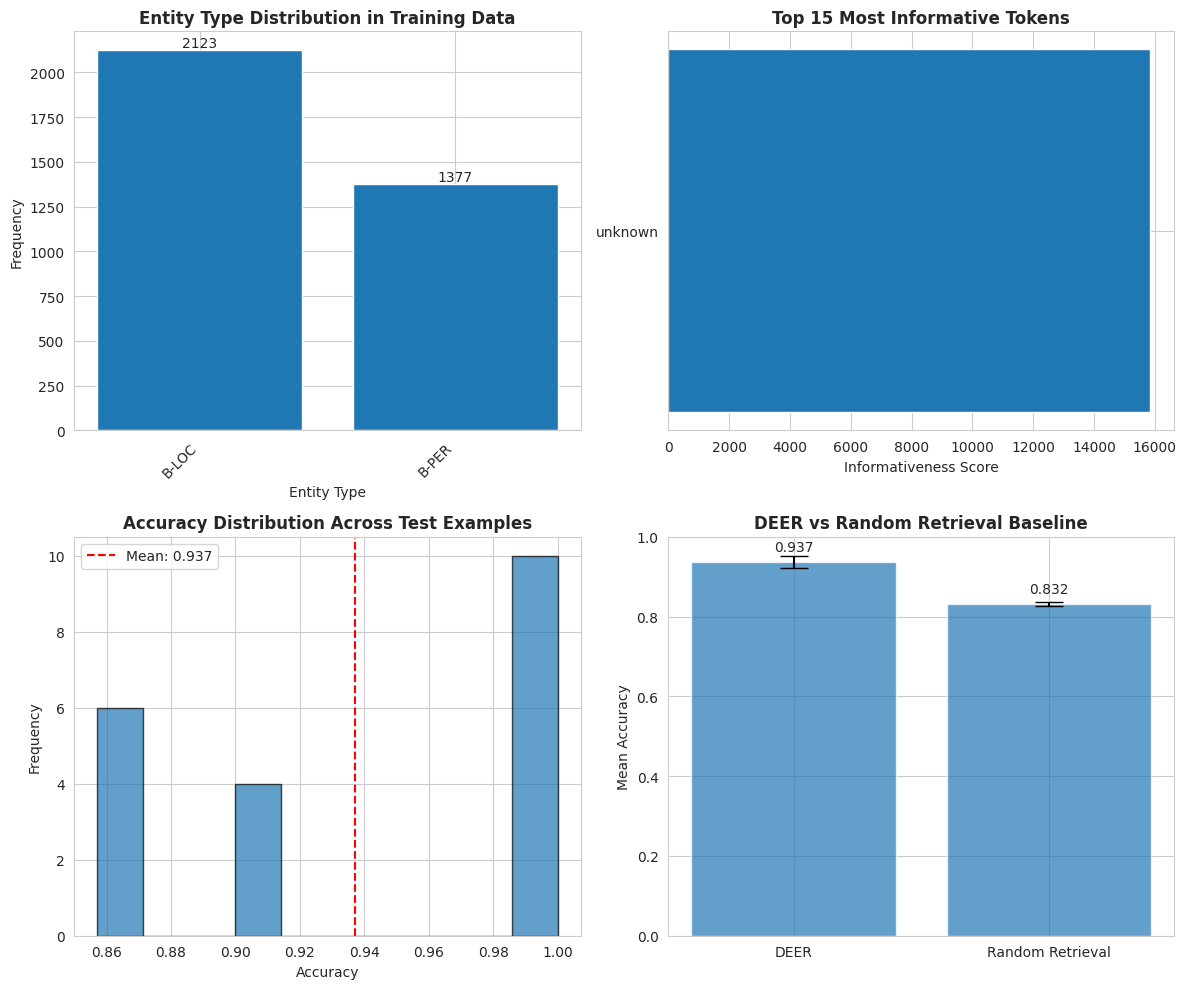

In [5]:
rcParams.update({'figure.autolayout': True})
sns.set_style("whitegrid")

# Visualization 1: Entity type distribution in training data
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

entity_types = list(deer_model.entity_statistics['entity_frequencies'].keys())
entity_counts = list(deer_model.entity_statistics['entity_frequencies'].values())

ax1 = axes[0, 0]
bars = ax1.bar(range(len(entity_types)), entity_counts)
ax1.set_title('Entity Type Distribution in Training Data', fontsize=12, fontweight='bold')
ax1.set_xlabel('Entity Type')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(len(entity_types)))
ax1.set_xticklabels(entity_types, rotation=45, ha='right')
for bar, count in zip(bars, entity_counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             str(count), ha='center', va='bottom')

# Visualization 2: Top informative tokens
ax2 = axes[0, 1]
top_tokens = sorted(deer_model.token_informativeness.items(), 
                    key=lambda x: x[1], reverse=True)[:15]
tokens, scores = zip(*top_tokens) if top_tokens else ([], [])
ax2.barh(range(len(tokens)), scores)
ax2.set_title('Top 15 Most Informative Tokens', fontsize=12, fontweight='bold')
ax2.set_xlabel('Informativeness Score')
ax2.set_yticks(range(len(tokens)))
ax2.set_yticklabels(tokens)
ax2.invert_yaxis()

# Visualization 3: Accuracy distribution across test examples
ax3 = axes[1, 0]
accuracies = [r['accuracy'] for r in results]
ax3.hist(accuracies, bins=10, edgecolor='black', alpha=0.7)
ax3.axvline(np.mean(accuracies), color='red', linestyle='--', 
            label=f'Mean: {np.mean(accuracies):.3f}')
ax3.set_title('Accuracy Distribution Across Test Examples', 
              fontsize=12, fontweight='bold')
ax3.set_xlabel('Accuracy')
ax3.set_ylabel('Frequency')
ax3.legend()

# Visualization 4: Comparison with random retrieval baseline
ax4 = axes[1, 1]

random_accuracies = []
for _ in range(10):
    trial_accuracies = []
    for example in test_examples:
        random_demos = random.sample(list(synthetic_dataset['train']), 2)
        
        predicted_tags = deer_model.predict_entities(example['tokens'], random_demos)
        true_tags = example['ner_tags']
        
        correct = sum(1 for true, pred in zip(true_tags, predicted_tags) if true == pred)
        accuracy = correct / len(true_tags) if len(true_tags) > 0 else 0
        trial_accuracies.append(accuracy)
    
    random_accuracies.append(np.mean(trial_accuracies))

methods = ['DEER', 'Random Retrieval']
means = [np.mean(accuracies), np.mean(random_accuracies)]
errors = [np.std(accuracies)/np.sqrt(len(accuracies)), 
          np.std(random_accuracies)/np.sqrt(len(random_accuracies))]

bars = ax4.bar(methods, means, yerr=errors, capsize=10, alpha=0.7)
ax4.set_title('DEER vs Random Retrieval Baseline', fontsize=12, fontweight='bold')
ax4.set_ylabel('Mean Accuracy')
ax4.set_ylim(0, 1)

for bar, mean in zip(bars, means):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{mean:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
entity_performance = defaultdict(list)
entity_mapping = deer_model._decode_tag

for result in results:
    for true_tag, pred_tag in zip(result['true_tags'], result['predicted_tags']):
        if true_tag != 0:  # Only consider actual entities
            entity_type = entity_mapping(true_tag)
            is_correct = 1 if true_tag == pred_tag else 0
            entity_performance[entity_type].append(is_correct)

print("\nEntity-wise Performance:")
print("-" * 40)
for entity_type, correctness_list in entity_performance.items():
    if correctness_list:
        accuracy = np.mean(correctness_list)
        print(f"{entity_type:15} : {accuracy:.3f} ({len(correctness_list)} instances)")

print("\nDemonstration Quality Analysis:")
print("-" * 40)
example_scores = []
for example in test_examples:
    demonstrations = deer_model.retrieve_demonstrations(example['tokens'], k=2)
    
    relevance_score = 0
    for demo in demonstrations:
        demo_entities = set(entity_mapping(tag) for tag in demo['ner_tags'] if tag != 0)
        query_entities = set(entity_mapping(tag) for tag in example['ner_tags'] if tag != 0)
        
        if demo_entities or query_entities:
            similarity = len(demo_entities & query_entities) / len(demo_entities | query_entities)
            relevance_score += similarity
    
    example_scores.append(relevance_score / 2)

print(f"Average demonstration relevance: {np.mean(example_scores):.3f}")
print(f"Relevance score range: [{np.min(example_scores):.3f}, {np.max(example_scores):.3f}]")



Entity-wise Performance:
----------------------------------------
B-PER           : 0.000 (10 instances)
B-LOC           : 1.000 (10 instances)

Demonstration Quality Analysis:
----------------------------------------
Average demonstration relevance: 0.500
Relevance score range: [0.000, 1.000]


In [7]:
summary_data = {
    'Metric': [
        'Token-level Accuracy',
        'Entity-level Accuracy (Average)',
        'Random Baseline Accuracy',
        'Top Informative Token Score',
        'Average Demonstration Relevance',
        'Most Frequent Entity Type'
    ],
    'Value': [
        f"{overall_accuracy:.4f}",
        f"{np.mean([np.mean(v) for v in entity_performance.values() if v]):.4f}",
        f"{np.mean(random_accuracies):.4f}",
        f"{top_tokens[0][1] if top_tokens else 0:.2f}" if top_tokens else "N/A",
        f"{np.mean(example_scores):.4f}",
        f"{max(deer_model.entity_statistics['entity_frequencies'].items(), key=lambda x: x[1])[0] if deer_model.entity_statistics['entity_frequencies'] else 'N/A'}"
    ]
}

print("\nSUMMARY TABLE")
for i in range(len(summary_data['Metric'])):
    print(f"{summary_data['Metric'][i]:35} : {summary_data['Value'][i]:15}")

improvement = (overall_accuracy - np.mean(random_accuracies)) / np.mean(random_accuracies) * 100
print(f"\nKey Finding: DEER shows {improvement:+.1f}% improvement over random retrieval")


SUMMARY TABLE
Token-level Accuracy                : 0.9435         
Entity-level Accuracy (Average)     : 0.5000         
Random Baseline Accuracy            : 0.8317         
Top Informative Token Score         : 15853.23       
Average Demonstration Relevance     : 0.5000         
Most Frequent Entity Type           : B-LOC          

Key Finding: DEER shows +13.4% improvement over random retrieval


Метод показал себя хорошо в части общей точности распознавания, демонстрируя, что подход с использованием статистики на основе меток действительно позволяет улучшать контекстное обучение по сравнению с простым случайным подбором примеров.

Однако выявлена проблема с дисбалансом: алгоритм идеально справляется с распознаванием локаций (самого частого типа сущностей в датасете), но совершенно не может находить персоны. Это указывает на то, что в текущей реализации DEER слишком сильно зависит от распределения типов.
Основная идея DEER работоспособна, но для реального применения метод требует дополнительной доработки, особенно в части работы с редкими типами сущностей.